In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import mysql.connector as connection
import os
import seaborn as sns
from scipy import stats

# Suppressing matplotlib and pandas warings
import warnings
warnings.filterwarnings("ignore")

# Setting style suitbable for disabled
plt.style.use('tableau-colorblind10')

Connecting to database

In [60]:
from dotenv import load_dotenv

# Loading data from .env used for connecting to database
load_dotenv()

connector = connection.connect(
    user=os.getenv("DB_USER"),
    database=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    password=os.getenv("DB_PASSWORD")
    )

Data base model

<img title="a title" alt="Alt text" src="mysql-sample-database.png">

List of countries

In [61]:
countries = pd.read_sql(
    """
    SELECT DISTINCT country
    FROM customers
    ORDER BY country
    """, connector)
countries

,country
0,Australia
1,Austria
2,Belgium
3,Canada
4,Denmark
5,Finland
6,France
7,Germany
8,Hong Kong
9,Ireland


Best selling countries

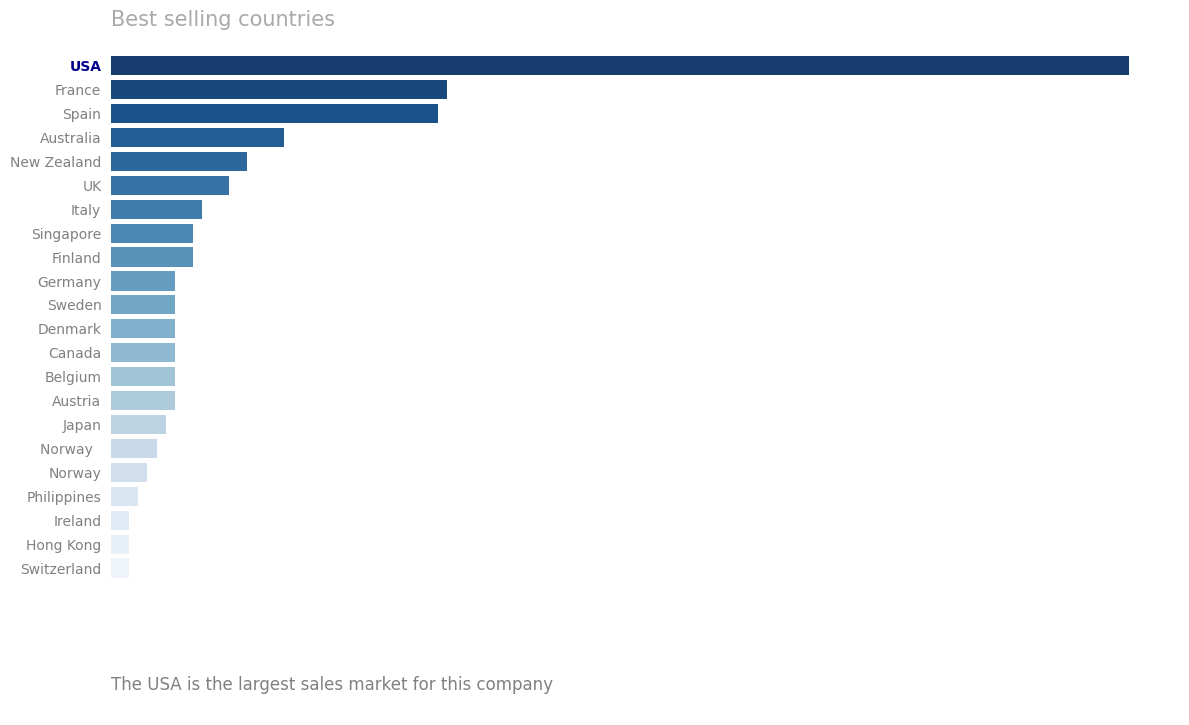

In [70]:
bestSellingCountries = pd.read_sql(
    """
    SELECT
        customers.country,
        COUNT(orders.orderNumber) AS totalOrders
    FROM customers
    INNER JOIN orders 
    ON customers.customerNumber = orders.customerNumber
    GROUP BY customers.country
    ORDER BY totalOrders DESC
    """, connector)

# Visualization of best selling countries
plt.figure(figsize=(12,6))
ax = sns.barplot(y=bestSellingCountries["country"],x=bestSellingCountries["totalOrders"], palette='Blues_r')
plt.title("Best selling countries", loc='left', fontsize=15, color='darkgrey', pad=20)
plt.xticks([])
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(color='grey')
plt.tick_params(axis='y', left=False)
plt.setp(ax.get_yticklabels()[0], color="darkblue", fontweight='bold')
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.tight_layout()

description="""
The USA is the largest sales market for this company.
"""
plt.text(0, -0.2, description, ha='left', va='center',
         transform=ax.transAxes, fontsize=12, color='grey')
plt.show()

Best selling products

In [63]:
bestSellingProducts = pd.read_sql(
    """
    SELECT 
        products.productName,
        products.productScale,
        products.productLine,
        orderdetails.priceEach,
        SUM(orderdetails.quantityOrdered) AS totalQuantity
    FROM products
    INNER JOIN orderDetails 
    ON products.productCode = orderdetails.productCode
    INNER JOIN orders
    ON orderdetails.orderNumber = orders.orderNumber
    GROUP BY
		products.productName,
        products.productScale,
        products.productLine,
        orderdetails.priceEach
    ORDER BY totalQuantity DESC;
    """, connector)

bestSellingProducts["totalQuantity"] = bestSellingProducts["totalQuantity"].astype(int)
# Calculare revenue column
bestSellingProducts["revenue"] = bestSellingProducts["priceEach"] * bestSellingProducts["totalQuantity"]

bestSellingProducts.head(n=10)

,productName,productScale,productLine,priceEach,totalQuantity,revenue
0,1960 BSA Gold Star DBD34,1:24,Motorcycles,61.70,245,15116.50
1,ATA: B757-300,1:700,Planes,98.48,237,23339.76
2,1936 Chrysler Airflow,1:24,Vintage Cars,95.44,203,19374.32
3,1982 Ducati 900 Monster,1:24,Motorcycles,56.10,203,11388.30
4,1969 Corvair Monza,1:18,Classic Cars,145.04,200,29008.00
5,1957 Corvette Convertible,1:18,Classic Cars,120.53,198,23864.94
6,Corsair F4U ( Bird Cage),1:24,Planes,55.96,197,11024.12
7,1917 Grand Touring Sedan,1:18,Vintage Cars,153.00,195,29835.00
8,1930 Buick Marquette Phaeton,1:50,Vintage Cars,35.78,194,6941.32
9,1966 Shelby Cobra 427 S/C,1:24,Classic Cars,43.27,190,8221.30


Total revenue and units sold

In [64]:
totalRevenue = bestSellingProducts["revenue"].sum()
totalUnitsSold = bestSellingProducts["totalQuantity"].sum()
numberOfCustomers = pd.read_sql(
    """
    SELECT customerNumber
    FROM customers
    """, connector)

averageOfCustomers = pd.read_sql(
    """
    SELECT 
        AVG(customerAvgOrders.averageOrderPrice) AS averageOrderPriceAcrossAllCustomers
    FROM (
        SELECT 
            orders.customerNumber,
            AVG(orderTotals.totalPrice) AS averageOrderPrice
        FROM 
            orders
        INNER JOIN (
            SELECT 
                orderdetails.orderNumber,
                SUM(orderdetails.quantityOrdered * orderdetails.priceEach) AS totalPrice
            FROM 
                orderdetails
            GROUP BY 
                orderdetails.orderNumber
        ) AS orderTotals
        ON 
            orders.orderNumber = orderTotals.orderNumber
        GROUP BY 
            orders.customerNumber
    ) AS customerAvgOrders
    """, connector)

print(f"Total Units Sold: {totalUnitsSold}")
print(f"Total Revenue: {totalRevenue} USD")
print(f"Total customers: {numberOfCustomers.shape[0]}")
print(f"Average order value for individual customer: {averageOfCustomers.iloc[0, 0]:.2f} USD")

Total Units Sold: 105516
Total Revenue: 9604190.61 USD
Total customers: 122
Average order value for individual customer: 29049.30 USD


Average customer

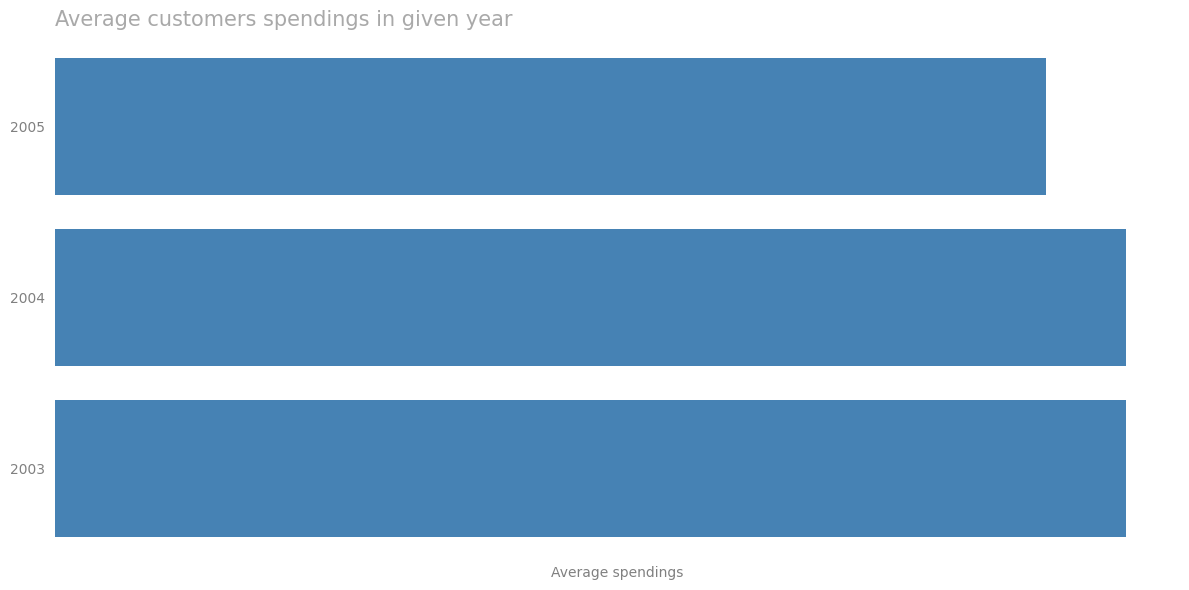

In [65]:
averageOfCustomersForGivenYear = pd.read_sql(
    """
    SELECT
        YEAR(orders.orderDate) AS orderYear,
        AVG(orderTotals.totalPrice) AS averageOrder
    FROM orders
    INNER JOIN (
        SELECT
            orderdetails.orderNumber,
            SUM(orderdetails.quantityOrdered * orderdetails.priceEach) AS totalPrice
        FROM orderdetails
        GROUP BY orderNumber
    ) AS orderTotals
    ON orders.orderNumber = orderTotals.orderNumber
    GROUP BY orderYear
    ORDER BY orderYear
    """, connector)

firstYear = averageOfCustomersForGivenYear["orderYear"].iloc[0]
lastYear = averageOfCustomersForGivenYear["orderYear"].iloc[len(averageOfCustomersForGivenYear) - 1]

plt.figure(figsize=(12, 6))
plt.barh(y=averageOfCustomersForGivenYear["orderYear"],
         width=averageOfCustomersForGivenYear["averageOrder"],color='steelblue')
plt.title('Average customers spendings in given year',
          loc='left', fontsize=15, color='darkgrey')
plt.xticks([])
plt.xlabel("Average spendings", color='grey')
plt.yticks(np.arange(firstYear, lastYear + 1,step=1), color="grey")
plt.tick_params(left=False)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.tight_layout()

Time series for orders

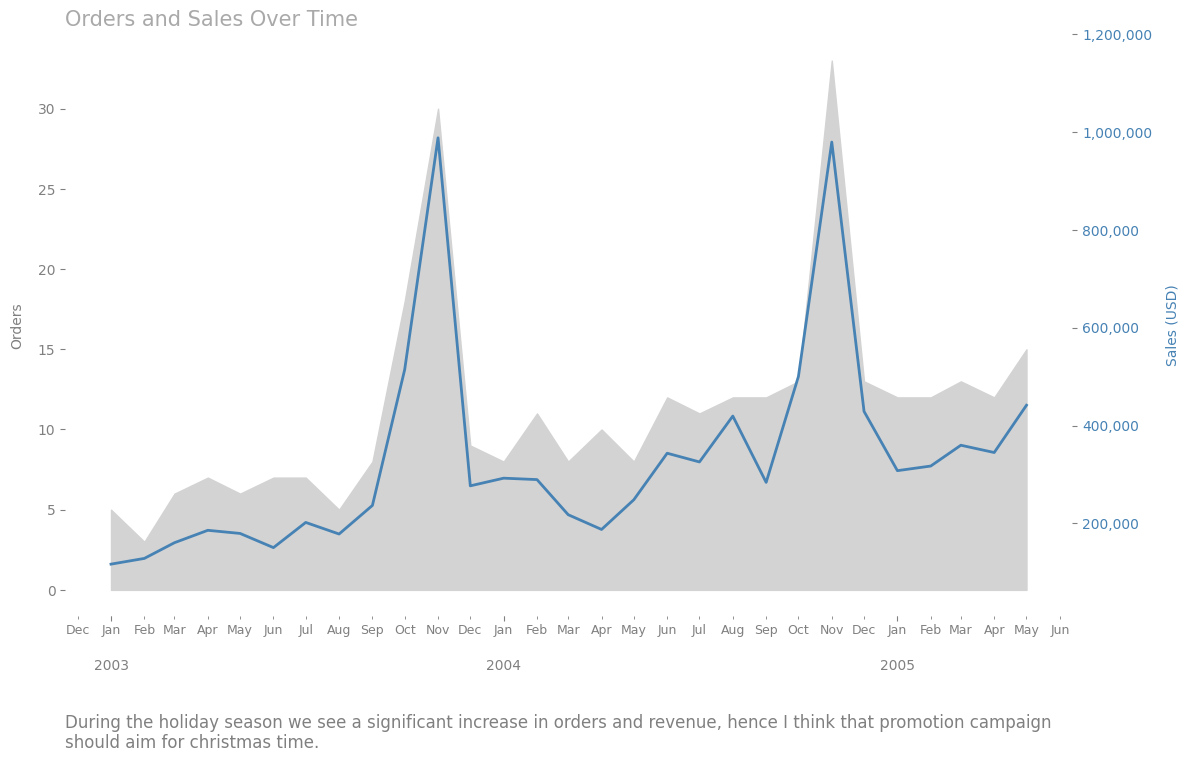

In [66]:
# We get date in format Year - Month
ordersInTime = pd.read_sql(
    """
    SELECT 
        COUNT(orderNumber) AS orderCount,
        DATE_FORMAT(orderDate, '%Y-%m') AS date
    FROM orders
    GROUP BY date
    ORDER BY date
    """, connector)

salesInTime = pd.read_sql(
    """
    SELECT
	    DATE_FORMAT(orders.orderDate, '%Y-%m') AS date,
        SUM(orderdetails.priceEach * orderdetails.quantityOrdered) AS orderValue
    FROM orders
    INNER JOIN orderdetails
    ON orderdetails.orderNumber = orders.orderNumber
    GROUP BY date
    """, connector)

# Convert date columns to datetime
ordersInTime['date'] = pd.to_datetime(ordersInTime['date'])
salesInTime['date'] = pd.to_datetime(salesInTime['date'])

fig, ax1 = plt.subplots(figsize=(12, 8))
# First y-axis
ax1.fill_between(
    ordersInTime["date"], ordersInTime["orderCount"], color='lightgray')
plt.title("Orders and Sales Over Time", loc='left', fontsize=15, color='darkgrey')
ax1.set_ylabel("Orders", color="gray", labelpad=10)

ax1.xaxis.remove_overlapping_locs = False
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax1.tick_params(axis='x', which='both', labelcolor='grey', color='gray')
ax1.tick_params(axis='x', which="minor", labelsize=9)
ax1.grid(False)

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(ordersInTime["date"], salesInTime["orderValue"], color='steelblue',linewidth=2)
ax2.set_ylabel('Sales (USD)', color='steelblue', labelpad=10)
ax1.tick_params(axis='y', color='gray', labelcolor='grey')
ax2.tick_params(axis='y', labelcolor='steelblue', color='gray')
ax2.set_ylim(10000, 1200000)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.grid(False)

# Add description    
description = """
During the holiday season we see a significant increase in orders and revenue, hence I think that promotion campaign \nshould aim for christmas time.
"""
plt.text(0, -0.2, description, ha='left', va='center',
         transform=ax1.transAxes, fontsize=12, color='grey')

fig.tight_layout()
plt.show()

Compare years for orders

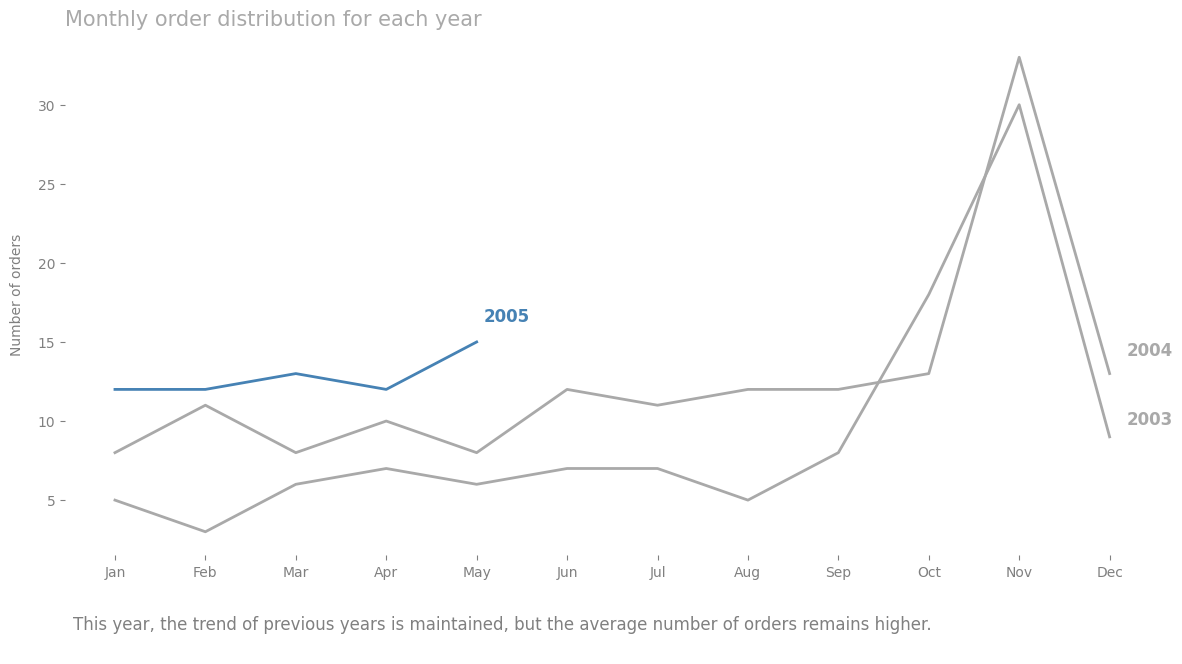

In [67]:
ordersInTime['date'] = pd.to_datetime(ordersInTime['date'], format='%Y-%m')   # Reformat date
# Divide date column into year and month columns
ordersInTime['year'] = ordersInTime['date'].dt.year
ordersInTime['month'] = ordersInTime['date'].dt.month
ordersInTimeByYears = ordersInTime.pivot(index='month', columns='year', values='orderCount')

# Visualization of monthly order distribution for each year
colorMap = {2003: 'darkgrey', 2004: 'darkgrey', 2005: 'steelblue'}
plt.figure(figsize=(12, 6))
for year in ordersInTimeByYears.columns:
    # Delete NaN values
    validData = ordersInTimeByYears[year].dropna()
    # Default color if year is not in color_map
    color = colorMap.get(year, 'black')
    # Handle each year annotation
    line, = plt.plot(ordersInTimeByYears.index,ordersInTimeByYears[year], label=year, color=color, linewidth=2)
    
    if not validData.empty:
        last_month = validData.index[-1]
        last_value = validData.iloc[-1]
        last_point = (last_month, last_value)

    plt.annotate(year, xy=last_point, textcoords='offset points', fontsize=12, color=color, fontweight="bold")

plt.title('Monthly order distribution for each year', loc='left', fontsize=15, color='darkgrey')
plt.xticks(ticks=range(1, 13), labels=[
           'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], color='gray')
plt.xlabel(None)
plt.ylabel('Number of orders', color='grey', labelpad=10)
plt.yticks(color='gray')
plt.tick_params(color='gray')

# Add description
description = """
This year, the trend of previous years is maintained, but the average number of orders remains higher.
"""
plt.figtext(0.065, -0.05, description, ha='left', va='center',
            fontsize=12, color='grey')
plt.tight_layout()
plt.show()

Credit limit and payments

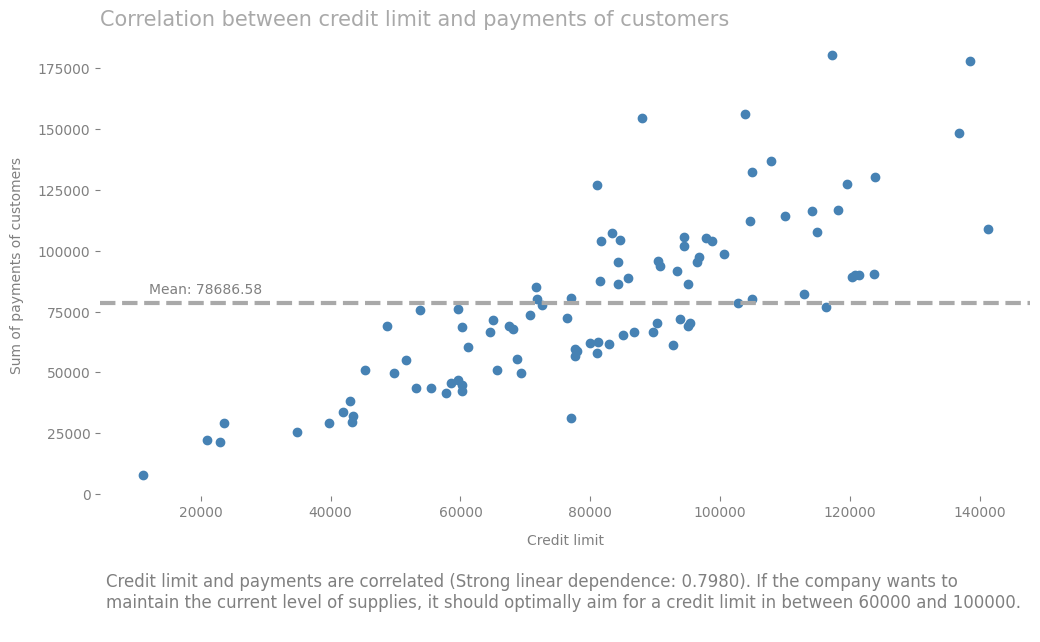

In [68]:
creditLimitAndPaymentsRaw = pd.read_sql(
    """
    SELECT 
        customers.creditLimit,
        SUM(payments.amount) as sumOfPayments
    FROM customers
    INNER JOIN payments
    ON customers.customerNumber = payments.customerNumber
    GROUP BY customers.customerNumber
    ORDER BY customers.creditLimit
    """, connector)

# Delete outliers
zScore = np.abs(stats.zscore(creditLimitAndPaymentsRaw))
threshold = 5
creditLimitAndPayments = creditLimitAndPaymentsRaw[(zScore < threshold).all(axis=1)]

# Correlation
corr, pVal = stats.pearsonr(
    creditLimitAndPayments["creditLimit"], creditLimitAndPayments["sumOfPayments"])

# Calculate mean and vector to plot mean line
meanOfPayments = np.mean(creditLimitAndPayments["sumOfPayments"])

# Calculate confidence interval
confidenceInterval = 0.05 * meanOfPayments
upperBound = meanOfPayments + confidenceInterval
lowerBound = meanOfPayments - confidenceInterval

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(creditLimitAndPayments["creditLimit"], creditLimitAndPayments["sumOfPayments"], color="steelblue")
plt.axhline(y=meanOfPayments, color='darkgrey',linewidth=3, linestyle='--', label="Mean Line")
plt.text(12000, meanOfPayments + 0.03 * meanOfPayments, f'Mean: {meanOfPayments:.2f}', color='grey', verticalalignment='bottom')
plt.title("Correlation between credit limit and payments of customers",
          loc="left", fontsize=15, color="darkgrey")
plt.tick_params(color='gray')
plt.xlabel("Credit limit", color="grey", labelpad=10)
plt.ylabel("Sum of payments of customers", color="grey", labelpad=10)
plt.xticks(color="grey")
plt.yticks(color="grey")
description = f"""
Credit limit and payments are correlated (Strong linear dependence: {corr:.4f}). If the company wants to \nmaintain the current level of supplies, it should optimally aim for a credit limit in between 60000 and 100000.
"""
plt.figtext(0.13, -0.05, description, ha='left', va='center', fontsize=12, color='grey')
plt.show()